In [1]:
import pandas as pd
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import PIL
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
import torchvision.transforms as T
import time
from matplotlib.patches import Rectangle
import json
from torch.utils.data import DataLoader

data_path = "/home/kevin/deep_learning/wildcam_eccv/"

# Make WildCam Dataset

In [2]:
class WildcamDetectionDataset(Dataset):
    """Wildcam Image Dataset"""

    def __init__(self, label_file, root_dir, transform=None, transform_size=None):
        self.root_dir = root_dir
        self.transform = transform
        self.transform_size = transform_size
        with open(label_file) as f:
            labels = json.load(f)
        cats = pd.DataFrame(labels['categories'])
        df = pd.DataFrame.from_dict(labels['annotations'])
        # only keep pics with boxes
        keep = [type(elem) == list for elem in df['bbox']]
        df = df.loc[keep]
        
        # get list of images
        self.images = list(df['image_id'])
        
        # generate labels
        # function for box adjustments
        def adjust_box(b):
            """ Adjust box format to x1, y1, x2, y2 instead of width and heigth"""
            if type(b) == list:
                b[2] = b[0] + b[2]
                b[3] = b[1] + b[3]
            else:
                b = []
            return b
        
        boxes = list(df['bbox'])
        boxes = [adjust_box(b) for b in boxes]
        boxes = [torch.Tensor(b) for b in boxes]
        boxes = torch.stack(boxes)

        # ids
        ids = list(df['category_id'])
        # change ids to all 1 as currently this dataset only contains boxes of animals
        ids = [1 for x in ids]
        
        # make list of dicts
        labels = []
        for i in range(len(boxes)):
            tmp = {'boxes': torch.stack([boxes[i]]),
                  'labels': torch.Tensor([ids[i]]).to(torch.int64)}
            labels.append(tmp)
        self.labels = labels

    
    def resize_bb(self, label, im_size):
        """Resize a bounding box"""
        for b in label['boxes']:
            x_ = self.transform_size / im_size[0]  
            y_ = self.transform_size / im_size[1]
            b[0] = b[0] * y_
            b[1] = b[1] * x_
            b[2] = b[2] * y_
            b[3] = b[3] * x_
        return label

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """ Get an image"""
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Load image
        img = self.images[idx]+".jpg"
        image = Image.open(os.path.join(self.root_dir, img))
        label = self.labels[idx]

        # Apply transform
        if self.transform is not None:
            im_size = np.array(image).shape
            # Transform image
            image = self.transform(image)
            if self.transform_size is not None:
                # Resize labels    
                label = self.resize_bb(label, im_size)

        return {'image': image, 'label': label}

In [3]:
def wildcam_collate_fn(batch):
    imgs = [item['image'] for item in batch]
    targets = [item['label'] for item in batch]
    return imgs, targets


root_dir = "/home/kevin/deep_learning/wildcam_eccv/eccv_18_cropped/"
label_file = os.path.join(data_path, "eccv_18_annotation_files/train_annotations.json")

# transform
transform = T.Compose([T.Resize((224, 224)),T.ToTensor()])

# create dataset
data = WildcamDetectionDataset(label_file=label_file, root_dir=root_dir, transform=transform, transform_size=224)

dataloader = DataLoader(data, batch_size = 2, shuffle=False, collate_fn=wildcam_collate_fn)

# Run Faster-RCNN model

In [4]:
n_classes = 2
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.train()
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=n_classes, bias=True)

In [7]:
it = iter(dataloader)
sample  = next(it)
loss = model(sample[0], sample[1])
loss

{'loss_classifier': tensor(0.5894, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.0008, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.2089, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0097, grad_fn=<DivBackward0>)}

In [12]:
test = v
test

tensor(0.8088)

[198.19272 220.43747 221.12708 223.71503]
tensor(1)
[ 31.57024   24.881975 211.10762  177.9701  ]
tensor(1)
[ 23.574816  25.15913  175.1197   111.36988 ]
tensor(1)
[100.08686   52.16814  184.13852  125.811356]
tensor(1)
[ 12.349031  27.865286 109.95419  116.65515 ]
tensor(1)


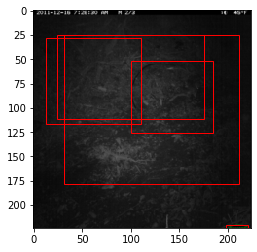

[116.603546 116.6138   136.47171  163.8432  ]
tensor(1)
[199.6297  130.33852 222.2819  179.2396 ]
tensor(1)
[ 17.238815   0.874325 224.       194.70596 ]
tensor(1)
[103.47525 118.03331 133.14699 162.1208 ]
tensor(1)
[200.34796 220.1947  221.9004  223.59863]
tensor(1)
[ 63.63601 112.5134  136.63184 173.3342 ]
tensor(1)


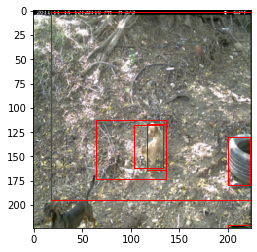

[197.26065 220.13898 223.76984 223.55554]
tensor(1)
[206.77684   33.440235 215.87666   42.89657 ]
tensor(1)
[ 54.199646  78.832016  82.54685  115.1312  ]
tensor(1)
[  0.         8.980029 224.       209.3714  ]
tensor(1)
[ 35.878273  42.22918  197.918    175.23387 ]
tensor(1)


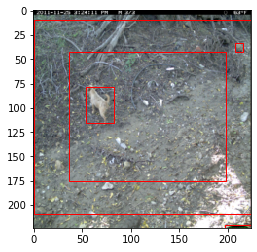

[ 35.35787  77.00209 218.76152 216.47154]
tensor(1)
[105.652054  71.45135  135.54095  101.83297 ]
tensor(1)
[206.41783  33.09153 215.7004   42.99647]
tensor(1)
[ 11.806014  11.460868 224.       181.10487 ]
tensor(1)
[ 22.385334 152.9431    33.139828 164.57434 ]
tensor(1)
[175.36488   11.832431 221.69252  105.08533 ]
tensor(1)


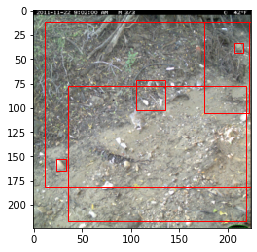

[ 21.243958  17.311329 213.50594  201.18547 ]
tensor(1)
[198.79143 219.66563 220.83543 223.41641]
tensor(1)
[ 97.90346   59.591843 176.0572   189.5826  ]
tensor(1)
[  1.0186316 101.66461   209.26651   215.20328  ]
tensor(1)
[ 13.789445  22.38899  165.01256  131.10645 ]
tensor(1)


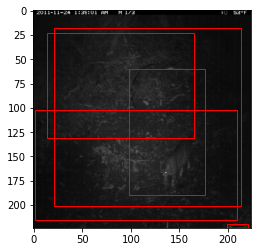

[ 10.924862  40.441475 202.66983  213.74458 ]
tensor(1)
[200.26324 220.4415  222.02313 223.66855]
tensor(1)
[ 99.53211   58.136597 165.37206  113.93772 ]
tensor(1)
[ 78.68397   45.874123 190.82959  192.99434 ]
tensor(1)
[  1.4310864 124.103096  199.68495   216.90215  ]
tensor(1)
[ 43.88989      0.28788698 223.2945     162.68082   ]
tensor(1)
[ 92.31676   51.572933 181.70546  138.09431 ]
tensor(1)


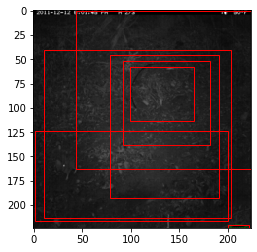

[199.6923  127.53725 222.45612 175.10115]
tensor(1)
[107.102646 103.335106 141.68785  126.6712  ]
tensor(1)
[206.51328   32.98722  215.78264   41.643673]
tensor(1)
[ 12.358136    3.7557154 224.        213.35435  ]
tensor(1)
[200.17506 219.89186 221.64677 223.29865]
tensor(1)
[ 78.74749   29.330675 220.16293  173.89098 ]
tensor(1)


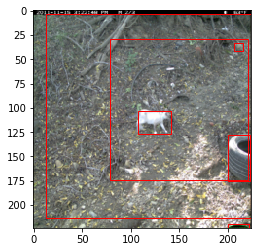

[ 97.265     51.209053 196.59329  160.62872 ]
tensor(1)
[199.00507 219.14717 220.35196 222.99393]
tensor(1)
[  3.20109     5.9553404 224.        224.       ]
tensor(1)
[ 23.644705  35.04519  169.7614   141.60127 ]
tensor(1)
[ 71.28389   27.181124 220.77245  187.92485 ]
tensor(1)
[197.859   220.37764 221.76216 224.     ]
tensor(1)
[ 32.94648  65.66552 168.005   178.33696]
tensor(1)


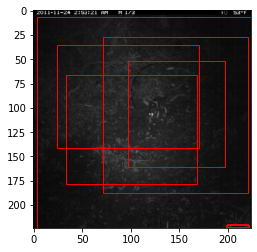

[ 22.283789   5.343853 143.20625  118.26319 ]
tensor(1)
[206.73785  32.93878 215.75104  42.43995]
tensor(1)
[199.70384 127.36312 223.23369 179.9703 ]
tensor(1)
[201.23166 219.8315  221.62006 223.40967]
tensor(1)
[ 83.76075   7.52233 224.      134.63821]
tensor(1)
[4.6492919e-02 9.4927416e+00 2.1791919e+02 1.9371042e+02]
tensor(1)
[  1.4067547  10.06787   113.58431    94.11283  ]
tensor(1)


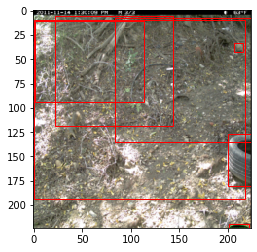

[100.60439  55.77556 164.7442  112.92653]
tensor(1)
[198.72095 219.86913 221.16815 223.49019]
tensor(1)
[151.43733 117.04258 176.65381 164.93405]
tensor(1)
[  8.766663  11.952807 216.99062  214.20137 ]
tensor(1)
[100.10039   56.784966 114.82369  101.62353 ]
tensor(1)


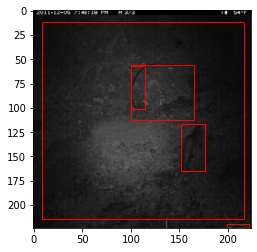

In [13]:
## a few examples
model.eval()

for i in range(10):
    sample = next(it)
    pred = model(sample[0])
    pred_boxes = pred[0]['boxes'].detach().numpy()
    labels = pred[0]['labels']
    plt.imshow(sample[0][0].permute(1, 2, 0))
    
    # Get the current reference
    ax = plt.gca()

    for i in range(len(pred_boxes)):
        box = pred_boxes[i]
        lab = labels[i]
        print(box)
        print(lab)
        box_width = box[2] - box[0]
        box_height = box[3] - box[1]

        # Create a Rectangle patch
        rect = Rectangle((box[0],box[1]),box_width, box_height,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()

# Training
With a custom Dataset/DataLoader that works with the pre-trained FasterRCNN model, I can test around with training the model.

In [13]:
def dict_on_gpu(d, device):
    d['boxes'] = d['boxes'].to(device)
    d['labels'] = d['labels'].to(device)
    return(d)

In [ ]:
# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Get the model
n_classes = 2
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.train()
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=n_classes, bias=True)
model.to(device)

# Create new dataset with bigger batches
root_dir = "/home/kevin/deep_learning/wildcam_eccv/eccv_18_cropped/"
label_file = os.path.join(data_path, "eccv_18_annotation_files/train_annotations.json")
batch_size = 2
transform = T.Compose([T.Resize((224, 224)),T.ToTensor()])
data = WildcamDetectionDataset(label_file=label_file, root_dir=root_dir, transform=transform, transform_size=224)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, collate_fn=wildcam_collate_fn)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):
    for i, batch in enumerate(dataloader):
        images = batch[0]
        labels = batch[1]
        images = [img.to(device) for img in images]
        labels = [dict_on_gpu(lab, device) for lab in labels]

        optimizer.zero_grad()
        
        loss_dict = model(images, labels)

        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()
        
        if i % 50 == 0:
            print(i)
            print(losses.item())

0
0.5342932939529419
50
0.15027514100074768
